# Testing How Best To Determine Point Removal

In [141]:
import os
import tsplib95
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import signal
import tqdm
from multiprocess import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import *
from scipy.stats import ttest_ind
from statistics import mean
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.neighbors import KernelDensity

from wsp import tsp, ds

INCLUDE_LEAVES = False
# FILE_DIR, N = "DATA_GEN_20p0.25", 20
# FILE_DIR, N = "DATA_GEN_30p0.33", 30
FILE_DIR, N = "DATA_GEN_50p0.33", 50
AX = np.array([None, None])
S_FACTOR = 2.0
S_FACTOR_B = 4.0
TREE_TYPE = ds.PKPRQuadTree

In [142]:
top_problems = sorted(os.listdir(FILE_DIR))


len(top_problems)

5

## Problem Injestion

In [143]:
def filter_leaves(decomp):
    return all(not tree.leaf for tree in decomp) if not INCLUDE_LEAVES else True

def count_wspd(wspd):
    return sum(1 for x in wspd if filter_leaves(x[0]))

def mean_sep(pair_sep_dict):
    return mean(special_dist.sep for pair, special_dist in pair_sep_dict.items() if filter_leaves(pair))

def sum_sep(pair_sep_dict):
    return sum(special_dist.sep for pair, special_dist in pair_sep_dict.items() if filter_leaves(pair))

def rel_diff(a,b):
    return float('nan') if a == 0 and b == 0 else (a - b) / (a + b)

In [178]:
base_df = pd.DataFrame(columns=['name', 
                                'parent', 
                                'path_reduction', 
                                'path_discount', 
                                'optimal_percent', 
                                'removal_count', 
                                'wsp_spec_reduction', 
                                'wsp_spec_reduction_B', 
                                'wsp_spec_reduction_sep', 
                                'wsp_spec_reduction_sep_B', 
                                'point_specific_wsp', 
                                'point_specific_wsp_B', 
                                'point_specific_wsp_weighted', 
                                'point_specific_wsp_weighted_B', 
                                'point_specific_sep_share', 
                                'point_specific_sep_share_B', 
                                'point_average_cost', 
                                'point_maximum_cost', 
                                'point_minimum_cost', 
                                'point_average_cost_weighted', 
                                'point_maximum_cost_weighted', 
                                'point_minimum_cost_weighted',
                                'point_specific_wsp_all', 
                                'point_specific_wsp_B_all', 
                                'point_specific_wsp_weighted_all', 
                                'point_specific_wsp_weighted_B_all', 
                                'point_specific_sep_share_all', 
                                'point_specific_sep_share_B_all'])
base_df = base_df.astype({'name': str, 'parent': str, 'path_reduction': float, 'path_discount': float, 'optimal_percent': float, 'removal_count': int, 'wsp_spec_reduction': float, 'wsp_spec_reduction_B': float, 'wsp_spec_reduction_sep_B': float, 'wsp_spec_reduction_sep': float, 'point_specific_wsp': float, 'point_specific_wsp_B': float, 'point_specific_wsp_weighted': float, 'point_specific_wsp_weighted_B': float, 'point_specific_sep_share': float, 'point_specific_sep_share_B': float, 'point_average_cost': float, 'point_maximum_cost': float, 'point_minimum_cost': float, 'point_average_cost_weighted': float, 'point_maximum_cost_weighted': float, 'point_minimum_cost_weighted': float, 'point_specific_wsp_all': float, 'point_specific_wsp_B_all': float, 'point_specific_wsp_weighted_all': float, 'point_specific_wsp_weighted_B_all': float, 'point_specific_sep_share_all': float, 'point_specific_sep_share_B_all': float})
base_df.set_index('name', inplace=True)

In [179]:
removed_problems : list[tsplib95.models.StandardProblem] = []
def setup(top_problem):
    main_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{top_problem}.tsp")
    main_conc_cost = float(main_problem.comment.split(' ')[2])
    main_points = [ds.Point(*main_problem.node_coords[i]) for i in main_problem.get_nodes()]

    main_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR)
    main_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR_B)

    main_cost = main_problem_object.calc_dist(
        [main_points[i-1] for i in main_problem.tours[0]] + [main_points[main_problem.tours[0][0] - 1]]
    )

    updates = base_df.copy()

    best_discount = float('inf')

    total_sep = sum_sep(main_problem_object.pair_sep_dict)
    total_sep_B = sum_sep(main_problem_object_B.pair_sep_dict)
    main_count_wspd = count_wspd(main_problem_object.wspd)
    main_count_wspd_B = count_wspd(main_problem_object_B.wspd)
    main_mean_sep = mean_sep(main_problem_object.pair_sep_dict)
    main_mean_sep_B = mean_sep(main_problem_object_B.pair_sep_dict)
    for removal_name in os.listdir(f"{FILE_DIR}/{top_problem}"): # need to filter in only single point removals here
        if '_' not in removal_name: continue
        removed_point_numbers = [int(s.split('.')[0]) for s in removal_name.split('_')[1:]] # numbers of the missing point in the og
        removed_points = [main_points[i-1] for i in removed_point_numbers]

        sub_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{removal_name}")
        sub_conc_cost = float(sub_problem.comment.split(' ')[2])
        sub_points = [ds.Point(*sub_problem.node_coords[i]) for i in sub_problem.get_nodes()]
        sub_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR)
        sub_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR_B)
        sub_cost = sub_problem_object.calc_dist(
            [sub_points[i-1] for i in sub_problem.tours[0]] + [sub_points[sub_problem.tours[0][0] - 1]]
        )

        # Strict Inclusion
        point_specific_wsp_all = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and removed_points in tree
        )
        point_specific_wsp_B_all = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object_B.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and removed_points in tree
        )

        point_specific_wsp_sep_share_all = sum(
            special.sep for pair, special in main_problem_object.pair_sep_dict.items()
            if any(removed_points in tree for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        ) / total_sep

        point_specific_wsp_sep_share_B_all = sum(
            special.sep for pair, special in main_problem_object_B.pair_sep_dict.items()
            if any(removed_points in tree for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        ) / total_sep_B
        
        # Any inclusion
        point_specific_wsp_any = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and any(point in tree for point in removed_points)
        )
        point_specific_wsp_B_any = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object_B.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and any(point in tree for point in removed_points)
        )
        point_specific_wsp_sep_share_any = sum(
            special.sep for pair, special in main_problem_object.pair_sep_dict.items()
            if any(any(point in tree for point in removed_points) for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        ) / total_sep

        point_specific_wsp_sep_share_B_any = sum(
            special.sep for pair, special in main_problem_object_B.pair_sep_dict.items()
            if any(any(point in tree for point in removed_points) for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        ) / total_sep_B

        point_edge_costs = main_problem_object.dist_matrix_with_nan[[i - 1 for i in removed_point_numbers]]
        
        best_discount = min(best_discount, (sub_conc_cost / main_conc_cost))

        updates.loc[sub_problem.name] = {
            'parent': top_problem,
            'path_reduction': sub_conc_cost / main_conc_cost,
            'path_discount': 1.0 - (sub_conc_cost / main_conc_cost),
            'removal_count': len(removed_point_numbers),
            'wsp_spec_reduction': rel_diff(main_count_wspd, count_wspd(sub_problem_object.wspd)),
            'wsp_spec_reduction_B': rel_diff(main_count_wspd_B, count_wspd(sub_problem_object_B.wspd)),
            'wsp_spec_reduction_sep': rel_diff(main_mean_sep, mean_sep(sub_problem_object.pair_sep_dict)),
            'wsp_spec_reduction_sep_B': rel_diff(main_mean_sep_B, mean_sep(sub_problem_object_B.pair_sep_dict)),
            'point_specific_wsp': point_specific_wsp_any,
            'point_specific_wsp_B': point_specific_wsp_B_any,
            'point_specific_wsp_weighted': point_specific_wsp_any / main_count_wspd,
            'point_specific_wsp_weighted_B': point_specific_wsp_B_any / main_count_wspd_B,
            'point_specific_sep_share': point_specific_wsp_sep_share_any,
            'point_specific_sep_share_B': point_specific_wsp_sep_share_B_any,
            'point_average_cost': np.nanmean(point_edge_costs),
            'point_maximum_cost': np.nanmax(point_edge_costs),
            'point_minimum_cost': np.nanmin(point_edge_costs),
            'point_average_cost_weighted': np.nanmean(point_edge_costs) / main_cost,
            'point_maximum_cost_weighted': np.nanmax(point_edge_costs) / main_cost,
            'point_minimum_cost_weighted': np.nanmin(point_edge_costs) / main_cost,
            'point_specific_wsp_all': point_specific_wsp_all,
            'point_specific_wsp_B_all': point_specific_wsp_B_all,
            'point_specific_wsp_weighted_all': point_specific_wsp_all / main_count_wspd,
            'point_specific_wsp_weighted_B_all': point_specific_wsp_B_all / main_count_wspd_B,
            'point_specific_sep_share_all': point_specific_wsp_sep_share_all,
            'point_specific_sep_share_B_all': point_specific_wsp_sep_share_B_all
        }
    updates['optimal_percent'] = updates['path_discount'] / best_discount
    return updates

original_sigint_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)
pool = Pool(7) # NUMBER OF PROCESSES
signal.signal(signal.SIGINT, original_sigint_handler)

update_collection = []
u=0
try:
    with tqdm.tqdm(total=len(top_problems), unit="top problem") as pbar:
        for result in pool.imap_unordered(setup, top_problems):
            update_collection.append(result)
            pbar.update(1)
            prob_name = next(iter(result))
            u += 1
            # if result[prob_name] != {}:
            #     u += 1
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name, "last_updated": prob_name, "updated": u}})
            # else:
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name}})
except KeyboardInterrupt:
    print("Caught KeyboardInterrupt, terminating workers")
    pool.terminate()
else:
    pool.close()
pool.join()

print("Injesting updates")
reduction_df = pd.concat(update_collection)
reduction_df

100%|██████████| 5/5 [00:20<00:00,  4.08s/top problem]

Injesting updates


,parent,path_reduction,path_discount,optimal_percent,removal_count,wsp_spec_reduction,wsp_spec_reduction_B,wsp_spec_reduction_sep,wsp_spec_reduction_sep_B,point_specific_wsp,...,point_minimum_cost,point_average_cost_weighted,point_maximum_cost_weighted,point_minimum_cost_weighted,point_specific_wsp_all,point_specific_wsp_B_all,point_specific_wsp_weighted_all,point_specific_wsp_weighted_B_all,point_specific_sep_share_all,point_specific_sep_share_B_all
name,,,,,,,,,,,,,,,,,,,,,
aad50p0.33_43_46,aad50p0.33,0.998217,0.001783,0.002165,2,-0.012987,0.000000,-0.005551,-0.016554,13,...,1.184960,0.078821,0.219889,0.000016,0,0,0.0,0.0,0.0,0.0
aad50p0.33_18_42,aad50p0.33,0.967935,0.032065,0.038933,2,-0.037975,0.000000,-0.052957,-0.009511,10,...,738.135726,0.064992,0.189391,0.010201,0,0,0.0,0.0,0.0,0.0
aad50p0.33_16_47,aad50p0.33,0.993960,0.006040,0.007334,2,0.013333,0.018182,-0.009732,0.042215,10,...,22.028673,0.064285,0.188263,0.000304,0,0,0.0,0.0,0.0,0.0
aad50p0.33_3_26,aad50p0.33,0.998756,0.001244,0.001510,2,0.000000,0.000000,-0.000689,0.000160,8,...,38.400463,0.047946,0.136464,0.000531,0,0,0.0,0.0,0.0,0.0
aad50p0.33_3_32,aad50p0.33,0.999737,0.000263,0.000319,2,0.000000,0.000000,0.001159,0.000283,10,...,38.400463,0.067447,0.186624,0.000531,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aab50p0.33_5_17,aab50p0.33,0.982466,0.017534,0.021243,2,-0.022727,0.000000,0.002671,-0.003847,11,...,0.201757,0.049791,0.179651,0.000003,0,0,0.0,0.0,0.0,0.0
aab50p0.33_13_16,aab50p0.33,0.995120,0.004880,0.005912,2,0.061728,0.152542,0.050829,0.035980,17,...,257.151039,0.053159,0.170501,0.003837,0,0,0.0,0.0,0.0,0.0
aab50p0.33_14_23,aab50p0.33,0.977974,0.022026,0.026685,2,0.023810,0.000000,-0.015964,-0.014073,8,...,189.982028,0.057940,0.199797,0.002835,0,0,0.0,0.0,0.0,0.0


In [180]:
reduction_df = reduction_df[reduction_df['removal_count'] == 2]

In [181]:
ge0_reduc_df = reduction_df[reduction_df['point_specific_wsp'] > 0]
reduction_df['wsp_spec_reduction'].describe(), reduction_df['wsp_spec_reduction'].isna().sum()
# reduction_df = reduction_df[reduction_df['wsp_spec_reduction'].notna()]

(count    6125.000000
 mean        0.056047
 std         0.077408
 min        -0.216495
 25%         0.000000
 50%         0.040000
 75%         0.087379
 max         0.488372
 Name: wsp_spec_reduction, dtype: float64,
 np.int64(0))

## WSP Reduction Calculations
How much does the difference in global well seperated pairs actually predict anything

In [182]:
reduction_df = reduction_df[reduction_df['wsp_spec_reduction_B'].notna()]
reduction_df = reduction_df[reduction_df['wsp_spec_reduction'].notna()]

In [183]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["wsp_spec_reduction"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["wsp_spec_reduction", "wsp_spec_reduction_B"]])).fit()
results_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     137.8
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           1.79e-31
Time:                        11:08:18   Log-Likelihood:                 13525.
No. Observations:                6125   AIC:                        -2.705e+04
Df Residuals:                    6123   BIC:                        -2.703e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9842      0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     188.1
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           5.06e-80
Time:                        11:08:18   Log-Likelihood:                 13640.
No. Observations:                6125   AIC:                        -2.727e+04
Df Residuals:                    6122   BIC:                        -2.725e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9850      0.000   2370.345      0.000       0.984       0.986
wsp_spec_reduction       0.0505      0.008      6.351      0.000       0.035       0.066
wsp_spec_reduction_B    -0.0941      0.006    -15.274      0.000      -0.106      -0.082
==============================================================================
Omnibus:                     2986.299   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16593.919
Skew:                          -2.347   Prob(JB):                         0.00
Kurtosis:                       9.557   Cond. No.                         29.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [184]:
results2 = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2) + wsp_spec_reduction_B + I(wsp_spec_reduction_B**2)", data=reduction_df).fit()
results2_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     264.6
Date:                Sun, 29 Jun 2025   Prob (F-statistic):          6.21e-111
Time:                        11:08:18   Log-Likelihood:                 13711.
No. Observations:                6125   AIC:                        -2.742e+04
Df Residuals:                    6122   BIC:                        -2.740e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     192.3
Date:                Sun, 29 Jun 2025   Prob (F-statistic):          1.50e-155
Time:                        11:08:18   Log-Likelihood:                 13819.
No. Observations:                6125   AIC:                        -2.763e+04
Df Residuals:                    6120   BIC:                        -2.760e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9837      0.000   2396.859      0.000       0.983       0.984
wsp_spec_reduction               0.1446      0.011     12.669      0.000       0.122       0.167
I(wsp_spec_reduction ** 2)      -0.5002      0.044    -11.403      0.000      -0.586      -0.414
wsp_spec_reduction_B            -0.0694      0.009     -7.438      0.000      -0.088      -0.051
I(wsp_spec_reduction_B ** 2)    -0.0716      0.028     -2.576      0.010      -0.126      -0.017
==============================================================================
Omnibus:                     3032.994   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19565.039
Skew:                          -2.322   Prob(JB):                         0.00
Kurtosis:                      10.423   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1037681458.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1037681458.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


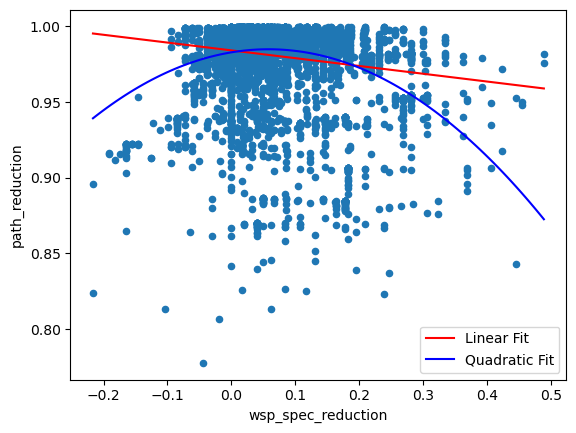

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1037681458.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9841834429799655)

In [185]:
reduction_df.plot.scatter("wsp_spec_reduction", "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df["wsp_spec_reduction"].min(), reduction_df["wsp_spec_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [186]:
reduction_df["wsp_spec_reduction"].values

array([-0.01298701, -0.03797468,  0.01333333, ...,  0.0617284 ,
        0.02380952,  0.0617284 ], shape=(6125,))

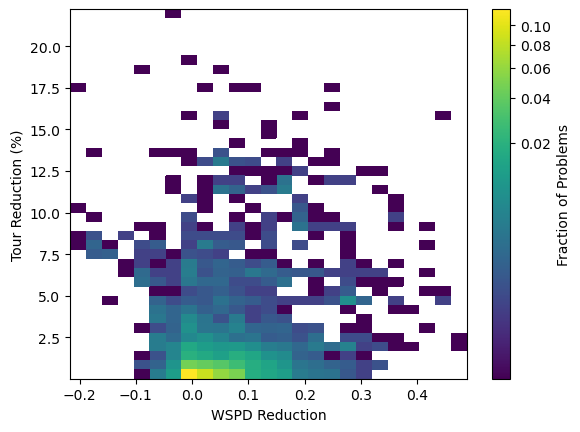

In [187]:
# dummy plot for no output

plt.style.use('default')  # Use the default (light) matplotlib style

h = plt.hist2d(
    reduction_df["wsp_spec_reduction"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.25),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["wsp_spec_reduction"])
norm = PowerNorm(0.25)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('WSPD Reduction')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

### Discount class predictions

In [188]:
COMPARISON_SIZE = 5
path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(COMPARISON_SIZE, 'path_reduction'))
path_largest = reduction_df.groupby("parent").apply(lambda df: df.nlargest(N-COMPARISON_SIZE, 'path_reduction'))

clf_df = pd.concat([
    path_smallest.assign(target=1),
    path_largest.assign(target=0)
])

# Create y to match clf_df
y = clf_df['target']

# Ensure problems with the same parent are either all in train or all in test
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
groups = clf_df['parent']
train_idx, test_idx = next(gss.split(clf_df, y, groups=groups))

X_train, X_test = clf_df.iloc[train_idx].reset_index(drop=True, level='parent'), clf_df.iloc[test_idx].reset_index(drop=True, level='parent')
y_train, y_test = y.iloc[train_idx].reset_index(drop=True, level='parent'), y.iloc[test_idx].reset_index(drop=True, level='parent')

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1218025974.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(COMPARISON_SIZE, 'path_reduction'))
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1218025974.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_largest = reduction_df.groupby("pare

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1986339396.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1986339396.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.057
Method:                 Least Squares   F-statistic:                    0.3494
Date:                Sun, 29 Jun 2025   Prob (F-statistic):              0.709
Time:                        11:08:18   Log-Likelihood:                 46.665
No. Observations:                  25   AIC:                            -87.33
Df Residuals:                      22   BIC:                            -83.67
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.8574      0.010     83.060      0.000       0.836       0.879
wsp_spec_reduction            -0.0465      0.064     -0.725      0.476      -0.180       0.087
I(wsp_spec_reduction ** 2)    -0.1106      0.411     -0.269      0.791      -0.964       0.743
==============================================================================
Omnibus:                        1.317   Durbin-Watson:                   0.793
Prob(Omnibus):                  0.518   Jarque-Bera (JB):                0.935
Skew:                          -0.134   Prob(JB):                        0.627
Kurtosis:                       2.091   Cond. No.                         51.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

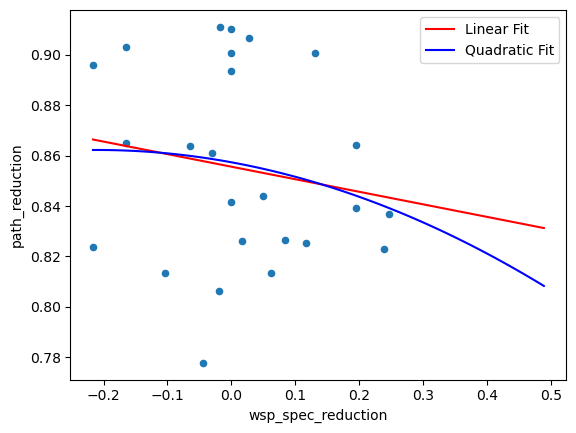

In [189]:
path_smallest.plot.scatter("wsp_spec_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"], sm.add_constant(path_smallest["wsp_spec_reduction"])).fit()

x = np.linspace(reduction_df["wsp_spec_reduction"].min(), reduction_df["wsp_spec_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

results2 = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2)", data=path_smallest).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')
plt.legend()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     18.92
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           2.07e-05
Time:                        11:08:18   Log-Likelihood:                 1598.5
No. Observations:                 225   AIC:                            -3193.
Df Residuals:                     223   BIC:                            -3186.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9996   1.75e-05   5.71e+04      0.000       1.000       1.000
wsp_spec_reduction    -0.0024      0.001     -4.350      0.000      -0.003      -0.001
==============================================================================
Omnibus:                       63.238   Durbin-Watson:                   0.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.787
Skew:                          -1.461   Prob(JB):                     7.20e-26
Kurtosis:                       4.953   Cond. No.                         40.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

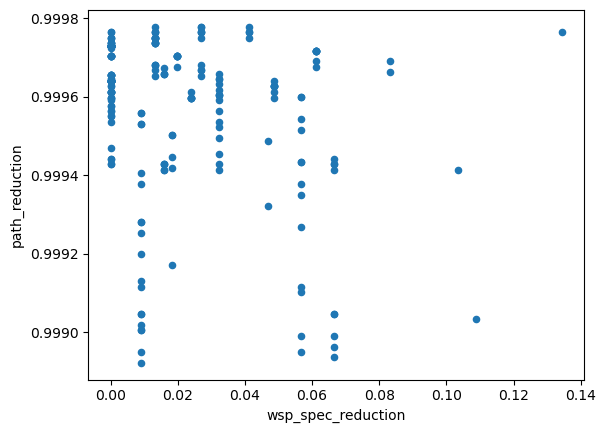

In [190]:
path_largest.plot.scatter("wsp_spec_reduction", "path_reduction")
results = sm.OLS(path_largest["path_reduction"], sm.add_constant(path_largest["wsp_spec_reduction"])).fit()
results.summary()

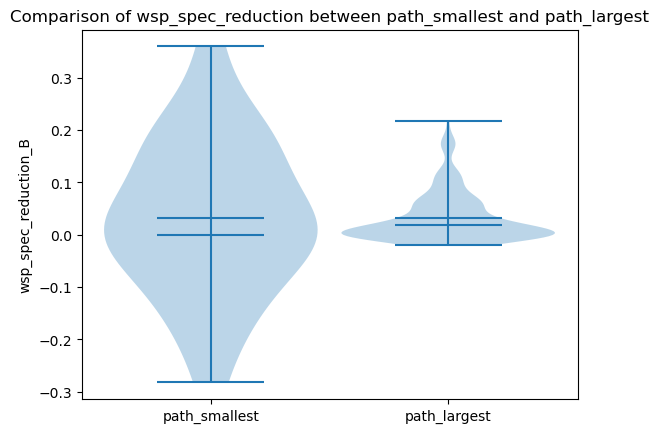

T-statistic: -0.0180, p-value: 0.9858
No statistically significant difference between means (p >= 0.05).


In [191]:
# Create a DataFrame for violin plot comparison
violin_data = [
    path_smallest['wsp_spec_reduction_B'],
    path_largest['wsp_spec_reduction_B']
]

plt.violinplot(violin_data, showmedians=True, showmeans=True, showextrema=True, points=100, widths=0.9)
plt.xticks([1, 2], ['path_smallest', 'path_largest'])
plt.ylabel('wsp_spec_reduction_B')
plt.title('Comparison of wsp_spec_reduction between path_smallest and path_largest')
plt.show()

# Perform independent t-test
stat, p_value = ttest_ind(
    path_smallest['wsp_spec_reduction_B'],
    path_largest['wsp_spec_reduction_B'],
    nan_policy='omit',
    equal_var=False  # Use Welch's t-test if variances are unequal
)

print(f"T-statistic: {stat:.4f}, p-value: {p_value:.4g}")
if p_value < 0.05:
    print("The means are statistically significantly different (p < 0.05).")
else:
    print("No statistically significant difference between means (p >= 0.05).")

In [192]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['wsp_spec_reduction', 'wsp_spec_reduction_B', 'wsp_spec_reduction_sep', 'wsp_spec_reduction_sep_B']].values, X_test[['wsp_spec_reduction', 'wsp_spec_reduction_B', 'wsp_spec_reduction_sep', 'wsp_spec_reduction_sep_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[-34.24620181  20.0590842   -5.35377333  23.88439085]] [-0.24087283]
              precision    recall  f1-score   support

           0       0.91      0.69      0.78        45
           1       0.12      0.40      0.19         5

    accuracy                           0.66        50
   macro avg       0.52      0.54      0.49        50
weighted avg       0.83      0.66      0.73        50

ROC AUC: 0.36444444444444446


We are able to do a fair job of predicting whether the number of wsps the problem is reduced by has a predictive effect on the shortness of the problem. 

In [193]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth=0.005)
kde_0 = KernelDensity(kernel='exponential', bandwidth=0.005)

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88        45
           1       0.27      0.60      0.38         5

    accuracy                           0.80        50
   macro avg       0.61      0.71      0.63        50
weighted avg       0.88      0.80      0.83        50

ROC AUC: 0.76


## How much does the wsps on a specific point actually matter

In [194]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["point_specific_wsp", "point_specific_wsp_B"]])).fit()
results_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     414.9
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           2.74e-89
Time:                        11:08:18   Log-Likelihood:                 13658.
No. Observations:                6125   AIC:                        -2.731e+04
Df Residuals:                    6123   BIC:                        -2.730e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9664      0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     242.8
Date:                Sun, 29 Jun 2025   Prob (F-statistic):          3.41e-102
Time:                        11:08:18   Log-Likelihood:                 13691.
No. Observations:                6125   AIC:                        -2.738e+04
Df Residuals:                    6122   BIC:                        -2.736e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9673      0.001   1193.719      0.000       0.966       0.969
point_specific_wsp       0.0005      0.000      3.778      0.000       0.000       0.001
point_specific_wsp_B     0.0012      0.000      8.141      0.000       0.001       0.001
==============================================================================
Omnibus:                     2974.411   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16361.904
Skew:                          -2.340   Prob(JB):                         0.00
Kurtosis:                       9.497   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [195]:
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2) + point_specific_wsp_B + I(point_specific_wsp_B**2)", data=reduction_df).fit()
results2_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     274.8
Date:                Sun, 29 Jun 2025   Prob (F-statistic):          5.30e-115
Time:                        11:08:18   Log-Likelihood:                 13720.
No. Observations:                6125   AIC:                        -2.743e+04
Df Residuals:                    6122   BIC:                        -2.741e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     186.2
Date:                Sun, 29 Jun 2025   Prob (F-statistic):          7.83e-151
Time:                        11:08:18   Log-Likelihood:                 13809.
No. Observations:                6125   AIC:                        -2.761e+04
Df Residuals:                    6120   BIC:                        -2.757e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9542      0.002    635.220      0.000       0.951       0.957
point_specific_wsp               0.0010      0.000      2.650      0.008       0.000       0.002
I(point_specific_wsp ** 2)   -3.137e-05    1.4e-05     -2.237      0.025   -5.89e-05   -3.88e-06
point_specific_wsp_B             0.0047      0.000     12.887      0.000       0.004       0.005
I(point_specific_wsp_B ** 2)    -0.0002   1.79e-05    -10.440      0.000      -0.000      -0.000
==============================================================================
Omnibus:                     2890.260   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15347.910
Skew:                          -2.274   Prob(JB):                         0.00
Kurtosis:                       9.282   Cond. No.                     1.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/830609850.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/830609850.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


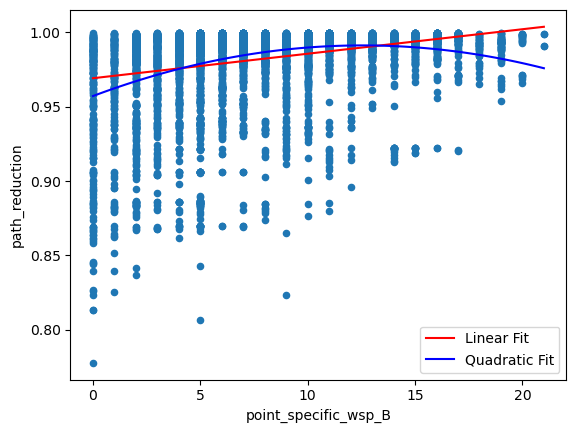

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/830609850.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9691709460283433)

In [244]:
reduction_df.plot.scatter("point_specific_wsp_B", "path_reduction")
# Plot the first fitted model
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp_B"])).fit()
x = np.linspace(reduction_df["point_specific_wsp_B"].min(), reduction_df["point_specific_wsp_B"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp_B + I(point_specific_wsp_B**2)", data=reduction_df).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

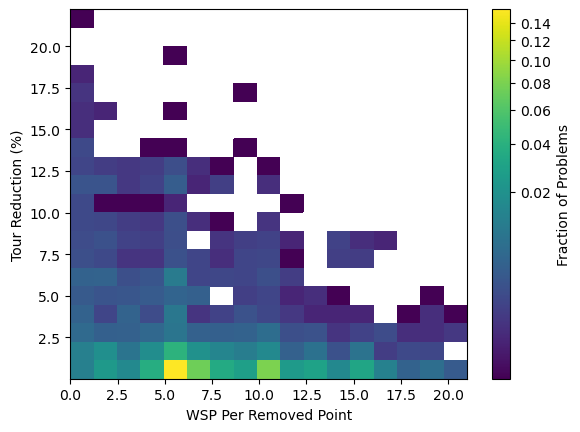

In [245]:
# dummy plot for no output

plt.style.use('default')  # Use the default (light) matplotlib style

h = plt.hist2d(
    reduction_df["point_specific_wsp_B"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(17,20),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_specific_wsp_B"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('WSP Per Removed Point')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [246]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_specific_wsp', 'point_specific_wsp_B']].values, X_test[['point_specific_wsp', 'point_specific_wsp_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[-0.44940595  0.10778228]] [2.72829174]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        45
           1       1.00      0.20      0.33         5

    accuracy                           0.92        50
   macro avg       0.96      0.60      0.65        50
weighted avg       0.93      0.92      0.90        50

ROC AUC: 0.8444444444444444


In [247]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth=0.005)
kde_0 = KernelDensity(kernel='exponential', bandwidth=0.005)

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.83      1.00      0.91         5

    accuracy                           0.98        50
   macro avg       0.92      0.99      0.95        50
weighted avg       0.98      0.98      0.98        50

ROC AUC: 1.0


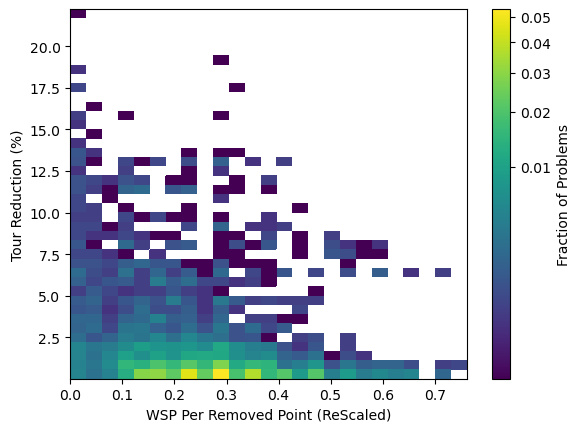

In [248]:
plt.style.use('default')  # Use the default (light) matplotlib style

h = plt.hist2d(
    reduction_df["point_specific_wsp_weighted_B"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_specific_wsp_weighted_B"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('WSP Per Removed Point (ReScaled)')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [249]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_specific_wsp_weighted', 'point_specific_wsp_weighted_B']].values, X_test[['point_specific_wsp_weighted', 'point_specific_wsp_weighted_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[-18.00420477   0.59244907]] [3.55912808]
              precision    recall  f1-score   support

           0       0.93      0.31      0.47        45
           1       0.11      0.80      0.20         5

    accuracy                           0.36        50
   macro avg       0.52      0.56      0.33        50
weighted avg       0.85      0.36      0.44        50

ROC AUC: 0.8577777777777778


In [250]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth='silverman')
kde_0 = KernelDensity(kernel='exponential', bandwidth='silverman')

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        45
           1       0.00      0.00      0.00         5

    accuracy                           0.90        50
   macro avg       0.45      0.50      0.47        50
weighted avg       0.81      0.90      0.85        50

ROC AUC: 1.0


/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

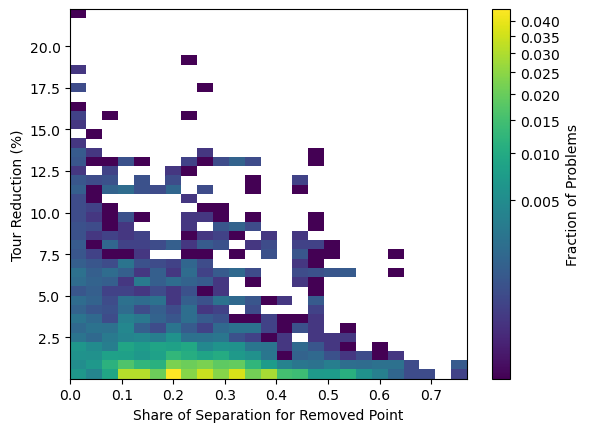

In [251]:
h = plt.hist2d(
    reduction_df["point_specific_sep_share_B"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_specific_sep_share_B"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('Share of Separation for Removed Point')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [252]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_specific_sep_share', 'point_specific_sep_share_B']].values, X_test[['point_specific_sep_share', 'point_specific_sep_share_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[-7.40845481 -7.96828612]] [2.7057295]
              precision    recall  f1-score   support

           0       1.00      0.31      0.47        45
           1       0.14      1.00      0.24         5

    accuracy                           0.38        50
   macro avg       0.57      0.66      0.36        50
weighted avg       0.91      0.38      0.45        50

ROC AUC: 1.0


In [253]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth='scott')
kde_0 = KernelDensity(kernel='exponential', bandwidth='scott')

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        45
           1       0.00      0.00      0.00         5

    accuracy                           0.90        50
   macro avg       0.45      0.50      0.47        50
weighted avg       0.81      0.90      0.85        50

ROC AUC: 1.0


/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

### Considering all metrics

In [254]:
# Subscript the training data
metrics = ['point_specific_wsp_weighted', 'point_specific_wsp_weighted_B', 'point_specific_wsp', 'point_specific_wsp_B', 'point_specific_sep_share', 'point_specific_sep_share_B',
           'wsp_spec_reduction', 'wsp_spec_reduction_B', 'wsp_spec_reduction_sep', 'wsp_spec_reduction_sep_B']
X_train_reduc, X_test_reduc = X_train[metrics].values, X_test[metrics].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[ 112.64344399 -137.08845185  -12.10420326    8.35290346  264.35351831
  -223.9132195   -99.69533879    6.04179877  -56.58156629  -78.70782446]] [37.56399275]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        45
           1       1.00      0.20      0.33         5

    accuracy                           0.92        50
   macro avg       0.96      0.60      0.65        50
weighted avg       0.93      0.92      0.90        50

ROC AUC: 0.4266666666666667


In [255]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth=0.02)
kde_0 = KernelDensity(kernel='exponential', bandwidth=0.02)

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.83      1.00      0.91         5

    accuracy                           0.98        50
   macro avg       0.92      0.99      0.95        50
weighted avg       0.98      0.98      0.98        50

ROC AUC: 1.0


/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/609549793.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Z = 1 - (results2_B.params[0] + results2_B.params[1] * X + results2_B.params[2] * X**2 + results2_B.params[3] * Y + results2_B.params[4] * Y**2)


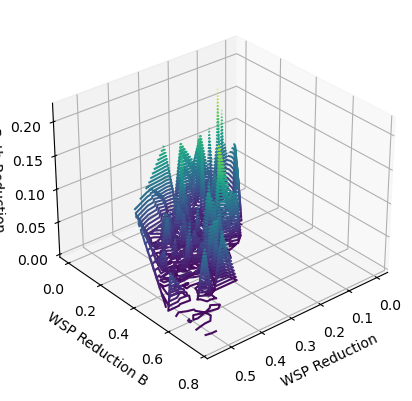

In [256]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
x = np.linspace(reduction_df["point_specific_wsp_weighted"].min(), reduction_df["point_specific_wsp_weighted"].max(), 100)
y = np.linspace(reduction_df["point_specific_wsp_weighted_B"].min(), reduction_df["point_specific_wsp_weighted_B"].max(), 100)
X, Y = np.meshgrid(x, y)
Z = 1 - (results2_B.params[0] + results2_B.params[1] * X + results2_B.params[2] * X**2 + results2_B.params[3] * Y + results2_B.params[4] * Y**2)
# ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
# Plot the scatter points
# ax.scatter(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], color='r', alpha=0.1)
ax.tricontour(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], 40, cmap='viridis')
ax.set_xlabel('WSP Reduction')
ax.set_ylabel('WSP Reduction B')
ax.set_zlabel('Path Reduction')

ax.view_init(azim=50, elev=30)

plt.show()

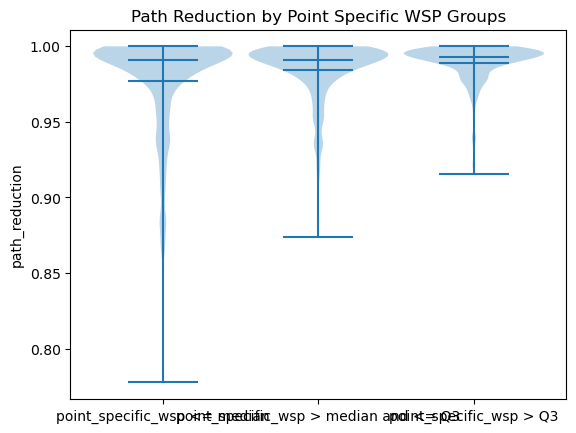

In [257]:
median = reduction_df['point_specific_wsp'].median()
q1 = reduction_df['point_specific_wsp'].quantile(0.25)
q3 = reduction_df['point_specific_wsp'].quantile(0.75)

data = [
    reduction_df[reduction_df['point_specific_wsp'] <= median]['path_reduction'],
    reduction_df[(reduction_df['point_specific_wsp'] > median) & (reduction_df['point_specific_wsp'] <= q3)]['path_reduction'],
    reduction_df[reduction_df['point_specific_wsp'] > q3]['path_reduction']
]

plt.violinplot(data, widths=0.9, points=100, showmeans=True, showmedians=True, showextrema=True)
plt.xticks([1, 2, 3], ['point_specific_wsp <= median', 'point_specific_wsp > median and <= Q3', 'point_specific_wsp > Q3'])
plt.ylabel('path_reduction')
plt.title('Path Reduction by Point Specific WSP Groups')
plt.show()

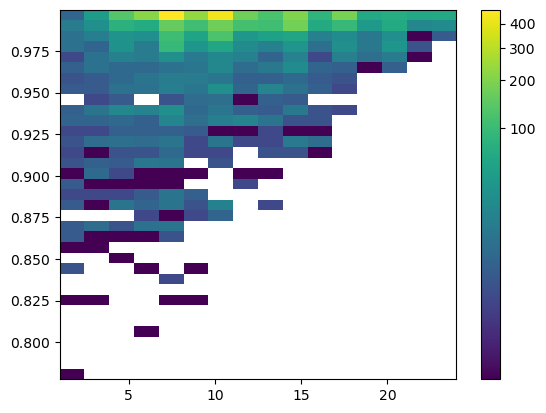

In [258]:
h = plt.hist2d(ge0_reduc_df["point_specific_wsp"], ge0_reduc_df["path_reduction"], bins=(16,35), cmin=1, norm=PowerNorm(0.25))
plt.colorbar(h[3])

## How well do other geometric tools work for this

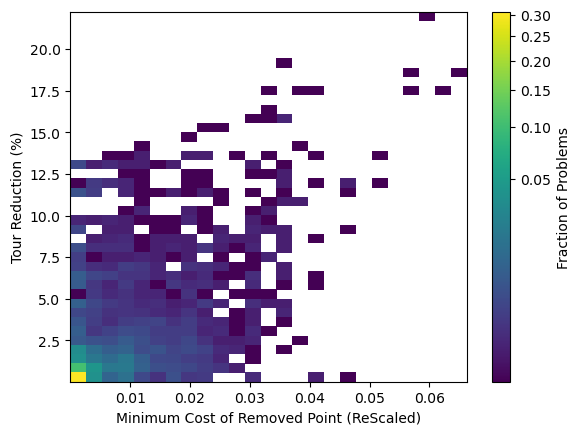

In [259]:
h = plt.hist2d(
    reduction_df["point_minimum_cost_weighted"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_minimum_cost_weighted"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('Minimum Cost of Removed Point (ReScaled)')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [260]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_minimum_cost_weighted']].values, X_test[['point_minimum_cost_weighted']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[448.73472137]] [-4.69108744]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

ROC AUC: 1.0


In [261]:
variable = "point_specific_wsp_weighted"

results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[variable])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     474.5
Date:                Sun, 29 Jun 2025   Prob (F-statistic):          2.17e-101
Time:                        11:11:50   Log-Likelihood:                 13685.
No. Observations:                6125   AIC:                        -2.737e+04
Df Residuals:                    6123   BIC:                        -2.735e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.9612      0.001    982.702      0.000       0.959       0.963
point_specific_wsp_weighted     0.0724      0.003     21.783      0.000       0.066       0.079
==============================================================================
Omnibus:                     2971.726   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16226.693
Skew:                          -2.341   Prob(JB):                         0.00
Kurtosis:                       9.455   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [262]:
results2 = smf.ols(formula=f"path_reduction ~ {variable} + I({variable}**2)", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     294.4
Date:                Sun, 29 Jun 2025   Prob (F-statistic):          8.13e-123
Time:                        11:11:50   Log-Likelihood:                 13738.
No. Observations:                6125   AIC:                        -2.747e+04
Df Residuals:                    6122   BIC:                        -2.745e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.9440      0.002    489.151      0.000       0.940       0.948
point_specific_wsp_weighted             0.2185      0.015     15.009      0.000       0.190       0.247
I(point_specific_wsp_weighted ** 2)    -0.2687      0.026    -10.306      0.000      -0.320      -0.218
==============================================================================
Omnibus:                     2917.665   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15619.286
Skew:                          -2.297   Prob(JB):                         0.00
Kurtosis:                       9.333   Cond. No.                         94.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1114625799.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1114625799.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


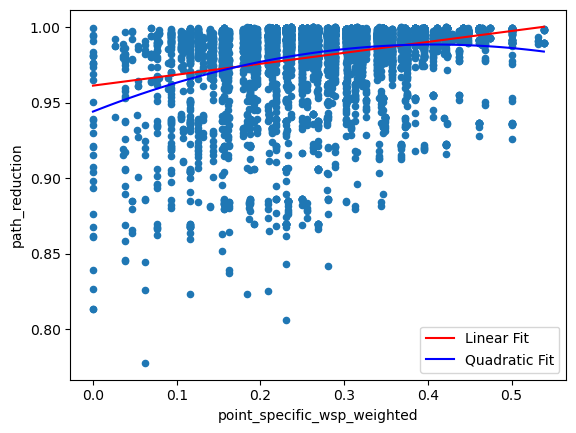

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1114625799.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9612449714434925)

In [263]:
reduction_df.plot.scatter(variable, "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df[variable].min(), reduction_df[variable].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [264]:
results2 = smf.ols(formula=f"optimal_percent ~ point_specific_wsp_weighted + I(point_specific_wsp_weighted**2) + point_average_cost_weighted + I(point_average_cost_weighted**2) + point_maximum_cost_weighted + point_maximum_cost_weighted + I(point_maximum_cost_weighted**2) + point_minimum_cost_weighted", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        optimal_percent   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     961.5
Date:                Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                        11:11:50   Log-Likelihood:                 14418.
No. Observations:                6125   AIC:                        -2.882e+04
Df Residuals:                    6117   BIC:                        -2.877e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.2244      0.008     27.767      0.000       0.209       0.240
point_specific_wsp_weighted            -0.1546      0.014    -11.378      0.000      -0.181      -0.128
I(point_specific_wsp_weighted ** 2)     0.1968      0.024      8.223      0.000       0.150       0.244
point_average_cost_weighted            -0.2358      0.115     -2.048      0.041      -0.461      -0.010
I(point_average_cost_weighted ** 2)     1.7132      0.718      2.387      0.017       0.306       3.120
point_maximum_cost_weighted            -2.3553      0.105    -22.426      0.000      -2.561      -2.149
I(point_maximum_cost_weighted ** 2)     7.4084      0.266     27.888      0.000       6.888       7.929
point_minimum_cost_weighted             0.7190      0.063     11.356      0.000       0.595       0.843
==============================================================================
Omnibus:                     1672.934   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6852.746
Skew:                           1.292   Prob(JB):                         0.00
Kurtosis:                       7.491   Cond. No.                     2.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [265]:
pca = sm.PCA(reduction_df[["point_specific_wsp_weighted", "point_average_cost_weighted", "point_maximum_cost_weighted", "point_minimum_cost_weighted"]][:5000].T)

pca.factors

,comp_0,comp_1,comp_2,comp_3
point_specific_wsp_weighted,-0.675216,-0.542064,-0.015815,-0.060656
point_average_cost_weighted,0.319448,0.086632,-0.800280,1.161282
point_maximum_cost_weighted,-0.257289,0.773130,0.293382,0.080776
point_minimum_cost_weighted,0.613057,-0.317697,0.522713,-0.853517


<Axes: xlabel='point_specific_wsp_weighted', ylabel='point_maximum_cost_weighted'>

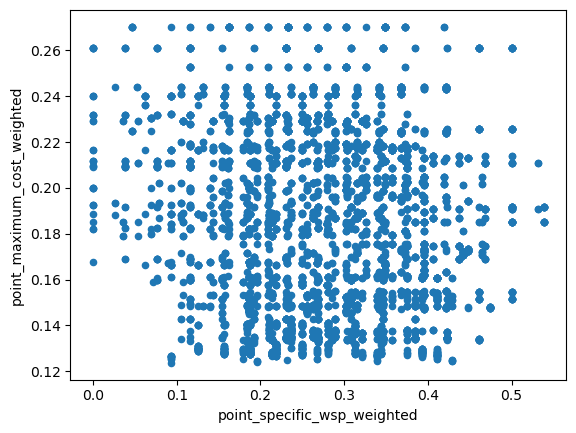

In [266]:
reduction_df.plot.scatter("point_specific_wsp_weighted", "point_maximum_cost_weighted")